[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Neuvork/Engeneering-thesis/blob/master/results.ipynb)

In [ ]:
! git clone https://<username>:<password>@github.com/Neuvork/Engeneeringthesis.git --single-branch --branch new_matrix_representation

Cloning into 'Engeneeringthesis'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 155 (delta 96), reused 99 (delta 44), pack-reused 0
Receiving objects: 100% (155/155), 1.57 MiB | 29.77 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#DOPISAC CMA
#ZROBIC REKURENCYJNY ES
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
import time
from IPython.display import clear_output
import copy
import cupy as cp
import tensorflow_datasets as tfds
import tensorflow as tf
from Engeneeringthesis.sigmas import Sigmas_Neural_Network
from Engeneeringthesis.NeuralNetwork import Neural_Network
from Engeneeringthesis.Cma_es import CMA_ES
from Engeneeringthesis.Logs import Logs
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist

In [2]:
!nvidia-smi

Sun Nov 29 14:01:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    13W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()
def cuda_memory_clear():
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()          

In [4]:
no_debug = 1
basic_debug_mode = 2
super_debug_mode = 3
only_interesting = 5
DEBUG_MODE = only_interesting

In [5]:
train_ds_mnist = tfds.load("mnist", split = "train", shuffle_files=True, batch_size=-1)
test_ds_mnist = tfds.load("mnist", split = "test", shuffle_files=True, batch_size=-1)

train_ds_mnist = tfds.as_numpy(train_ds_mnist)
test_ds_mnist = tfds.as_numpy(test_ds_mnist)

train_ds_mnist = {"image" : cp.array(train_ds_mnist["image"]/255., dtype=cp.float32), "label" : cp.array(train_ds_mnist["label"]) }
test_ds_mnist = {"image" : cp.array(test_ds_mnist["image"]/255., dtype=cp.float32), "label" : cp.array(test_ds_mnist["label"]) }

In [6]:
train_ds_mnist['image'] = train_ds_mnist['image'].reshape((60000, 1, 28, 28))

In [19]:
def evaluate_population(population, train_ds):
    create_input_time = 0
    preds_time = 0
    points_count_time = 0
    j  = 0
    if DEBUG_MODE % basic_debug_mode == 0:
      print("___EVALUATE_POPULATION_START")
    #scores = np.zeros(population.layers[0][1].shape[0], dtype = np.uint32)
    scores = cp.zeros(population.population_size, dtype = cp.uint32)
    for image, label in zip(cp.array(train_ds['image']), cp.array(train_ds['label'])):
        start = time.time()
        #image = image.flatten()
        images = cp.zeros(shape = (population.population_size, 1, 28, 28))
        for i in range(population.population_size):
          images[i] = image
        image = images
        create_input_time += time.time() - start
        start = time.time()
        preds = population.forward(image)
        preds_time += time.time() - start
        start = time.time()
        #scores += cp.asnumpy(preds == label)
        scores += preds == label
        points_count_time += time.time() - start
        j += 1
      
    if DEBUG_MODE % basic_debug_mode == 0:
      print("___EVALUATE_POPULATION_STOP", "create_input_time: ", create_input_time, "preds_time:", preds_time,
          "points_count_time: ", points_count_time, "\n best result: ", np.max(cp.asnumpy( scores)),
          "mean socre: ", np.mean(cp.asnumpy( scores)), "min score: ", np.min(cp.asnumpy( scores))) 
    if DEBUG_MODE % only_interesting == 0:
      print("best result: ", np.max(cp.asnumpy( scores)), "mean socre: ", np.mean(cp.asnumpy( scores)), "min score: ", np.min(cp.asnumpy( scores)))

    return scores

In [20]:
!nvidia-smi

Sun Nov 29 14:03:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    34W /  70W |    697MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
def custom_plot(ax, data):
  XD = np.array([1,2,3,4,5])
  ax.plot(XD)

In [22]:
logs = Logs([('matrix','covariance'),('vector','sigma'),
                      ('vector','isotropic'),('vector','anisotropic'),('vector','mean'),
                      ('number','best-score')])

('matrix', 'covariance')
('vector', 'sigma')
('vector', 'isotropic')
('vector', 'anisotropic')
('vector', 'mean')
('number', 'best-score')


In [23]:
logs = Logs([('matrix','covariance'),('population', 'population'),('number','sigma'),
                      ('vector','isotropic'),('vector','anisotropic'),('vector','mean'),
                      ('number','best-score'), ('vector', 'mean_act - mena_prev')])

('matrix', 'covariance')
('population', 'population')
('number', 'sigma')
('vector', 'isotropic')
('vector', 'anisotropic')
('vector', 'mean')
('number', 'best-score')
('vector', 'mean_act - mena_prev')


In [24]:
dimensionalities = []
for i in range(784):
  dimensionalities.append(10)
number_of_cages = 784

In [55]:
import cupy as cp
import numpy as np
from functools import reduce
from Engeneeringthesis.kernels import dot_cuda_paralell, max_pooling_cuda_paralell, convolve_cuda_paralell, dot_cuda_paralell_many_inputs

no_debug = 1
basic_debug_mode = 2
super_debug_mode = 3
only_interesting = 5
DEBUG_MODE = only_interesting
from Engeneeringthesis.kernels import dot_cuda_paralell, max_pooling_cuda_paralell, convolve_cuda_paralell
class Neural_Network:


  def __init__(self,num_nets,input_size,given_layers,loc=0,scale=.3, cage_dimensionalities = None):#after init in neuronized state
    self.mempool = cp.get_default_memory_pool()
    self.pinned_mempool = cp.get_default_memory_pool()
    self.population_size = num_nets
    self.input_size = input_size
    self.input_layers = given_layers
    self.vectorized = False #if NN is in state of being vectorized or neuronized
    self.layers = [] #empty if in vectorized,neural network if in neuronized
    self.matrix = None #empty if in neuronized, vector if in vectorized
    self.layers_shapes = self.parse_input(given_layers,input_size,num_nets) #remember the shape of network,and parse user input
    self.dimensionality = self.compute_dimensionality()
    self.cage_dimensionalities = cage_dimensionalities
    for layer in self.layers_shapes:
      if layer[0] == 'conv':
        self.layers.append(['conv', cp.random.normal(loc = loc, scale = scale, size = layer[1]).astype(cp.float32)])   #layer[0] -> conv ; layer[1] ->[num_nets, out_channel, in_channel, filter_wdth, filter_height]
      if layer[0] == 'linear':
        self.layers.append(['linear', cp.random.normal(loc = loc, scale = scale, size = layer[1]).astype(cp.float32)]) 
      if layer[0] == 'bias':
        self.layers.append(['bias', cp.zeros(shape = layer[1]).astype(cp.float32)])
  

  def cuda_memory_clear(self):
    self.mempool.free_all_blocks()
    self.pinned_mempool.free_all_blocks()          

  def parse_to_vector(self): # every individual is getting trapnsfered to vector
    ret_mat = np.zeros((self.population_size, self.dimensionality),dtype = np.float32)
    index = 0
    for layer in self.layers:
      i = 0
      for individual in layer[1]:
        ret_mat[i][index:index+individual.size] = cp.asnumpy(individual.flatten())
        i += 1 
      index += layer[1][0].flatten().size
    self.layers = []
    self.cuda_memory_clear()
    self.matrix = cp.array(ret_mat, dtype = cp.float32)
    self.vectorized = True

  def list_memory_clear(self, lista):
    for i in range(len(lista)):
      del lista[0]

  def parse_input(self,given_layers,input_size,num_nets):
    layers = []
    input_size = (input_size[0],input_size[1],input_size[2])

    iterator = 1
    for layer in given_layers:
      print(layer, input_size, type(input_size))

      if layer[0] == 'conv':
        layers.append((layer[0],[num_nets,layer[1][0],input_size[0],layer[1][1],layer[1][2]]))
        input_size = (layer[1][0],input_size[1]-layer[1][1]+1,input_size[2]-layer[1][2]+1)
        input_size = (input_size[0],np.ceil(input_size[1]/2),np.ceil(input_size[2]/2))
        input_size = tuple(map(lambda x:int(x), input_size))

      if layer[0] == 'linear':
        temp = 1
        if type(input_size) == int:
          temp = input_size
        else:
          temp = reduce( lambda a,b: a*b, input_size)
        input_size = int(temp)
        layers.append((layer[0],[num_nets,input_size,layer[1]]))
        input_size = layer[1]

      if iterator != len(given_layers):
        layers.append(('bias', [num_nets] + list(input_size)))
      iterator += 1
      
      
    print("layers: ", layers)
    return layers
  
  def compute_dimensionality(self):
    number_of_weights = 0
    for layer_shape in self.layers_shapes:
      print("layer_shape: ", layer_shape)
      weights_in_layer = reduce(lambda a,b: a*b, layer_shape[1][1:])
      number_of_weights += weights_in_layer
    return number_of_weights



  def sample(self,B,D, sigma, mean, lam):
    self.layers = [] #cleaning previous population
    self.cuda_memory_clear()
    #concat sampled vectors and parse them
    ret_mat = cp.zeros((lam, self.dimensionality),dtype = cp.float32)
    #L = cp.linalg.cholesky(covariance_matrix*(sigma**2)).astype(cp.float32)
    for i in range(lam):
      ret_mat[i] = self.multivariate_cholesky(mean,B,D,sigma)
      #ret_mat[i] = cp.random.multivariate_normal(mean, covariance_matrix * (sigma**2))
      self.cuda_memory_clear()
    self.matrix = ret_mat
    self.vectorized = True

  def multivariate_cholesky(self,mean,B,D,sigma):
    vector = cp.random.normal(loc = 0,scale = 1,size = self.dimensionality,dtype = cp.float32)
    ret_val = sigma*B.dot(D*vector) + mean
    return ret_val

  def caged_sample(self,covariance_matrices, sigmas, means, lam):
    self.layers = [] #cleaning previous population
    self.cuda_memory_clear()
    #concat sampled vectors and parse them
    ret_mat = cp.zeros((lam, self.dimensionality),dtype = cp.float32)
    L = []
    for i in range(len(self.cage_dimensionalities)):
      L.append(cp.linalg.cholesky(covariance_matrices[i]*(sigmas[i]**2)).astype(cp.float32))
    for i in range(lam):
      ret_mat[i] = self.caged_multivariate_cholesky(means,L)
    self.cuda_memory_clear()
    self.matrix = ret_mat
    self.vectorized = True
  
  def caged_multivariate_cholesky(self, means, cholesky_covariances):
    vector = cp.array([])
    for i in range(len(means)):
      sampled_vector = cp.random.normal(loc = 0,scale = 1,size = cholesky_covariances[i].shape[0],dtype = cp.float32)
      vector = cp.concatenate((vector, cholesky_covariances[i].dot(sampled_vector) + means[i]))
    return vector

  def mult(self, l):
    ret_val = 1
    for number in l:
      ret_val *= number
    return ret_val

  def parse_from_vectors(self):
    numbers = []
    self.matrix = cp.asnumpy(self.matrix)
    self.cuda_memory_clear()
    for layer in self.layers_shapes:
      print(layer[1])
      numbers.append(self.mult(layer[1][1:]))
    start = 0
    it = 0
    for number in numbers:
      self.layers.append((self.layers_shapes[it][0],cp.array(self.matrix[:,start:(start+number)]).reshape(self.layers_shapes[it][1])))
      it+=1
      start += number
    self.matrix = None
    self.vectorized = False

  def move_to_cpu(self):
    for layer in self.layers:
      layer[1] = cp.asnumpy(layer[1])

  def move_to_gpu(self):
    for layer in self.layers:
      layer[1] = cp.array(layer[1])

  def forward(self, state):
    layer_num = 0
    temp = state.copy()
    first_lin = 0
    for layer in self.layers:
      if layer[0]=='conv':
        temp = convolve_cuda_paralell(temp, layer[1])
        temp = max_pooling_cuda_paralell(temp)
      if layer[0]=='linear':
        if first_lin == 0 and False:
          first_lin+=1
          temp = temp.reshape(-1,layer[1].shape[1])
        if layer_num ==0:
          temp = dot_cuda_paralell(temp, layer[1])
        else:
          temp = dot_cuda_paralell_many_inputs(temp, layer[1])
      if layer[0] == 'bias':
        temp += layer[1]
        #temp = cp.tanh(temp, dtype = cp.float32)
    return cp.argmax(temp, axis = 1)

  def replace_individual(self, i, individual):
    i = int(i)
    for j in range(len(self.layers)):
      self.layers[j][1][i] = individual[j]
      self.list_memory_clear(individual)
    del individual

#self.cage dimensionalities 
  def return_chosen_ones(self, indices, number_of_cage = None):
    if not self.vectorized:
        self.parse_to_vector()
    
    if number_of_cage == None:
      return self.matrix[indices]
    else:
      begin = self.cage_dimensionalities[:number_of_cage].sum()
      move = self.cage_dimensionalities[number_of_cage]
      return self.matrix[indices, begin : begin + move]
      
      




  def get_individual(self, i):
    result_individual = []
    i = int(i)
    for layer in self.layers:
      result_individual.append(layer[1][i].copy())
    return result_individual


In [56]:
POPULATION_SIZE = 2
#input size do zmiany
population = Neural_Network(POPULATION_SIZE,  (1, 28, 28), 
                            [
                             ['conv', (1, 3, 3), [1.,1.]],
                             ['conv', (1, 3, 3), [1.,1.]],
                             ['linear', 10, [1.,1.]]
                             ],
                            cage_dimensionalities=np.array(dimensionalities))

['conv', (1, 3, 3), [1.0, 1.0]] (1, 28, 28) <class 'tuple'>
['conv', (1, 3, 3), [1.0, 1.0]] (1, 13, 13) <class 'tuple'>
['linear', 10, [1.0, 1.0]] (1, 6, 6) <class 'tuple'>
layers:  [('conv', [2, 1, 1, 3, 3]), ('bias', [2, 1, 13, 13]), ('conv', [2, 1, 1, 3, 3]), ('bias', [2, 1, 6, 6]), ('linear', [2, 36, 10])]
layer_shape:  ('conv', [2, 1, 1, 3, 3])
layer_shape:  ('bias', [2, 1, 13, 13])
layer_shape:  ('conv', [2, 1, 1, 3, 3])
layer_shape:  ('bias', [2, 1, 6, 6])
layer_shape:  ('linear', [2, 36, 10])


In [57]:
layers = copy.copy(population.layers)

In [58]:
population.parse_to_vector()
population.parse_from_vectors()

[2, 1, 1, 3, 3]
[2, 1, 13, 13]
[2, 1, 1, 3, 3]
[2, 1, 6, 6]
[2, 36, 10]


In [59]:
(population.layers[1][1] == layers[1][1]).all()

array(True)

In [60]:
population.layers[0][0]

'conv'

In [61]:
logs = Logs([('matrix','covariance'),('population', 'population'),('number','sigma'),
                      ('vector','isotropic'),('vector','anisotropic'),('vector','mean'),
                      ('number','best-score'), ('vector', 'mean_act - mena_prev')])

('matrix', 'covariance')
('population', 'population')
('number', 'sigma')
('vector', 'isotropic')
('vector', 'anisotropic')
('vector', 'mean')
('number', 'best-score')
('vector', 'mean_act - mena_prev')


In [62]:
population.matrix

In [63]:
classifier = CMA_ES(population, .05, evaluate_population, logs)

(583, 583) (583,)


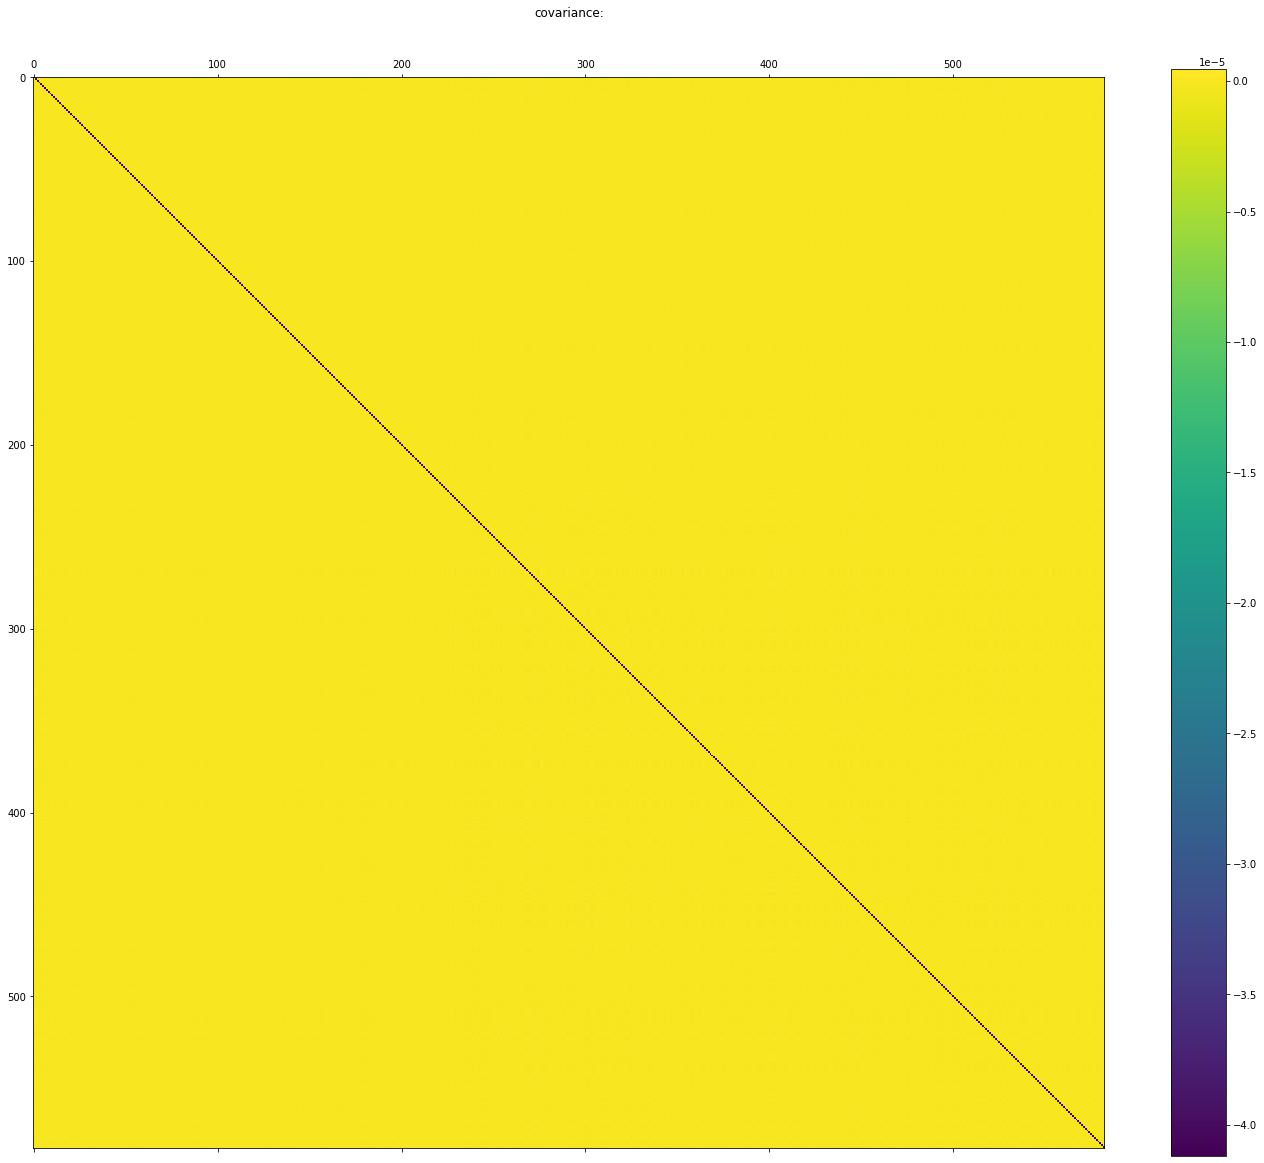

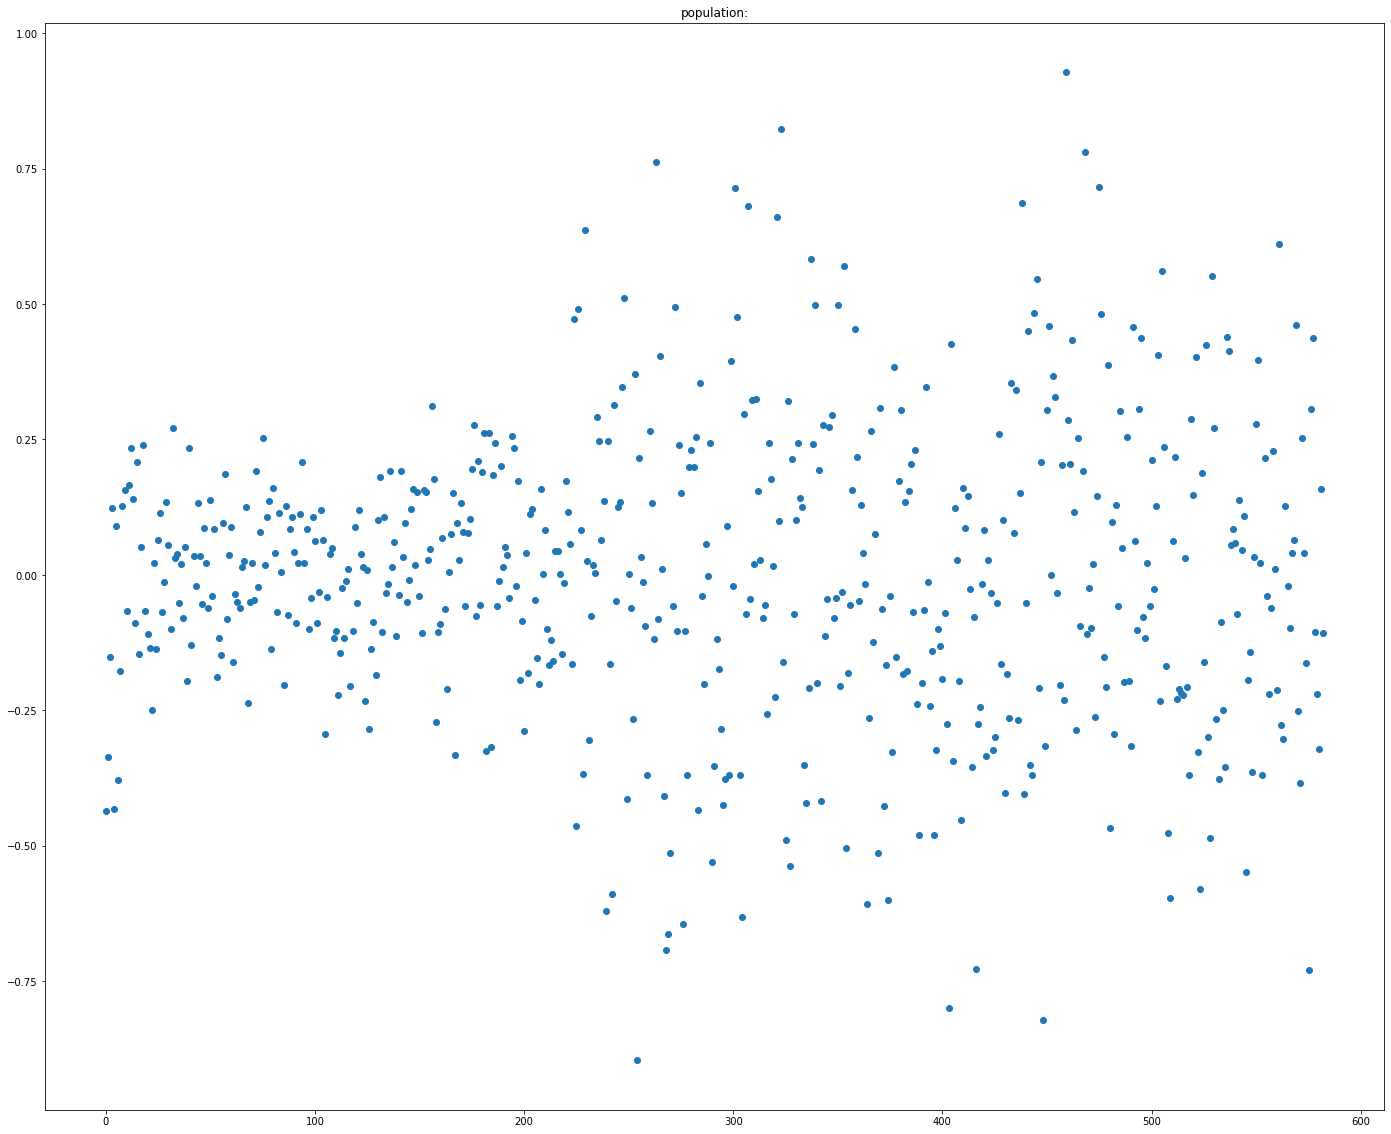

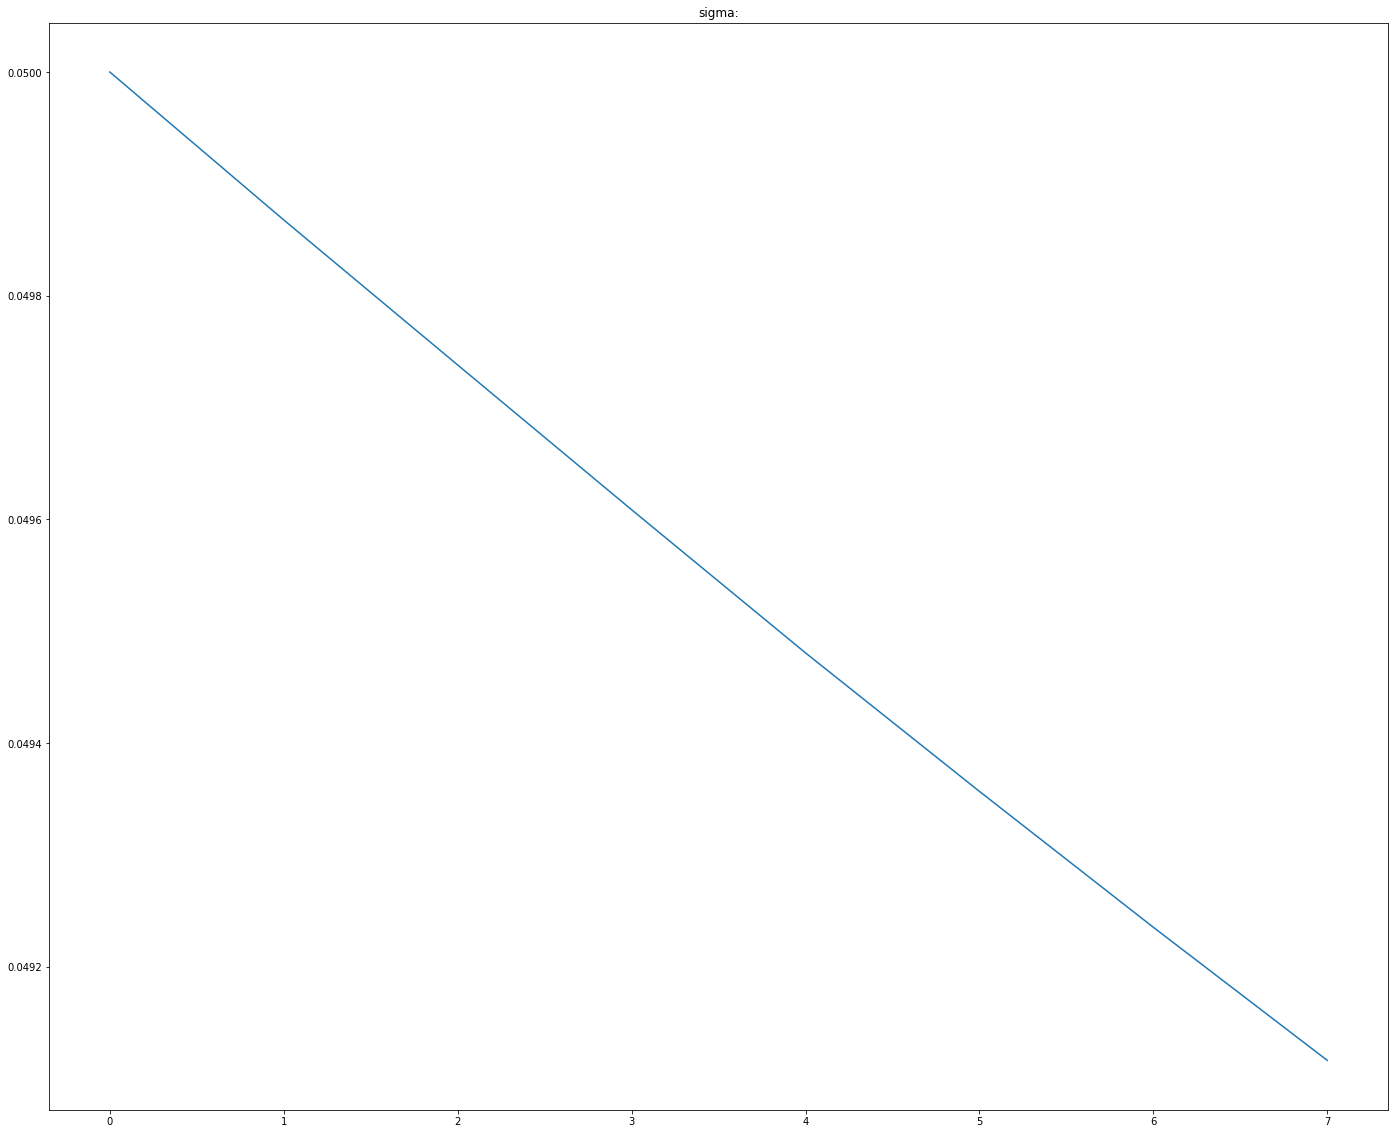

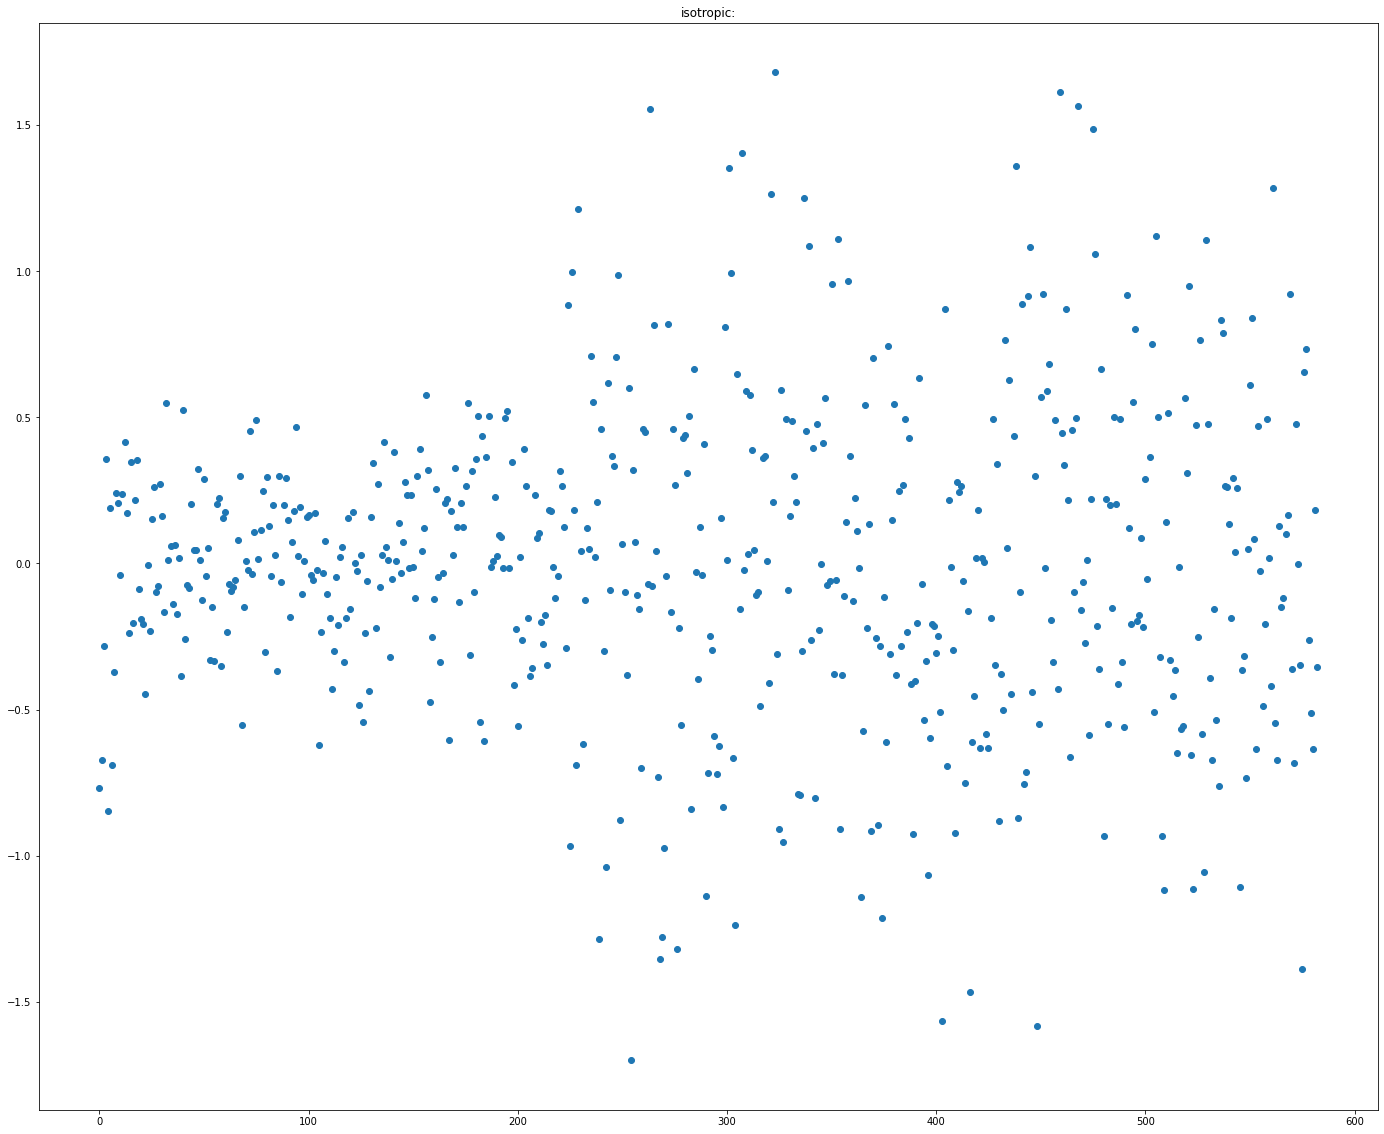

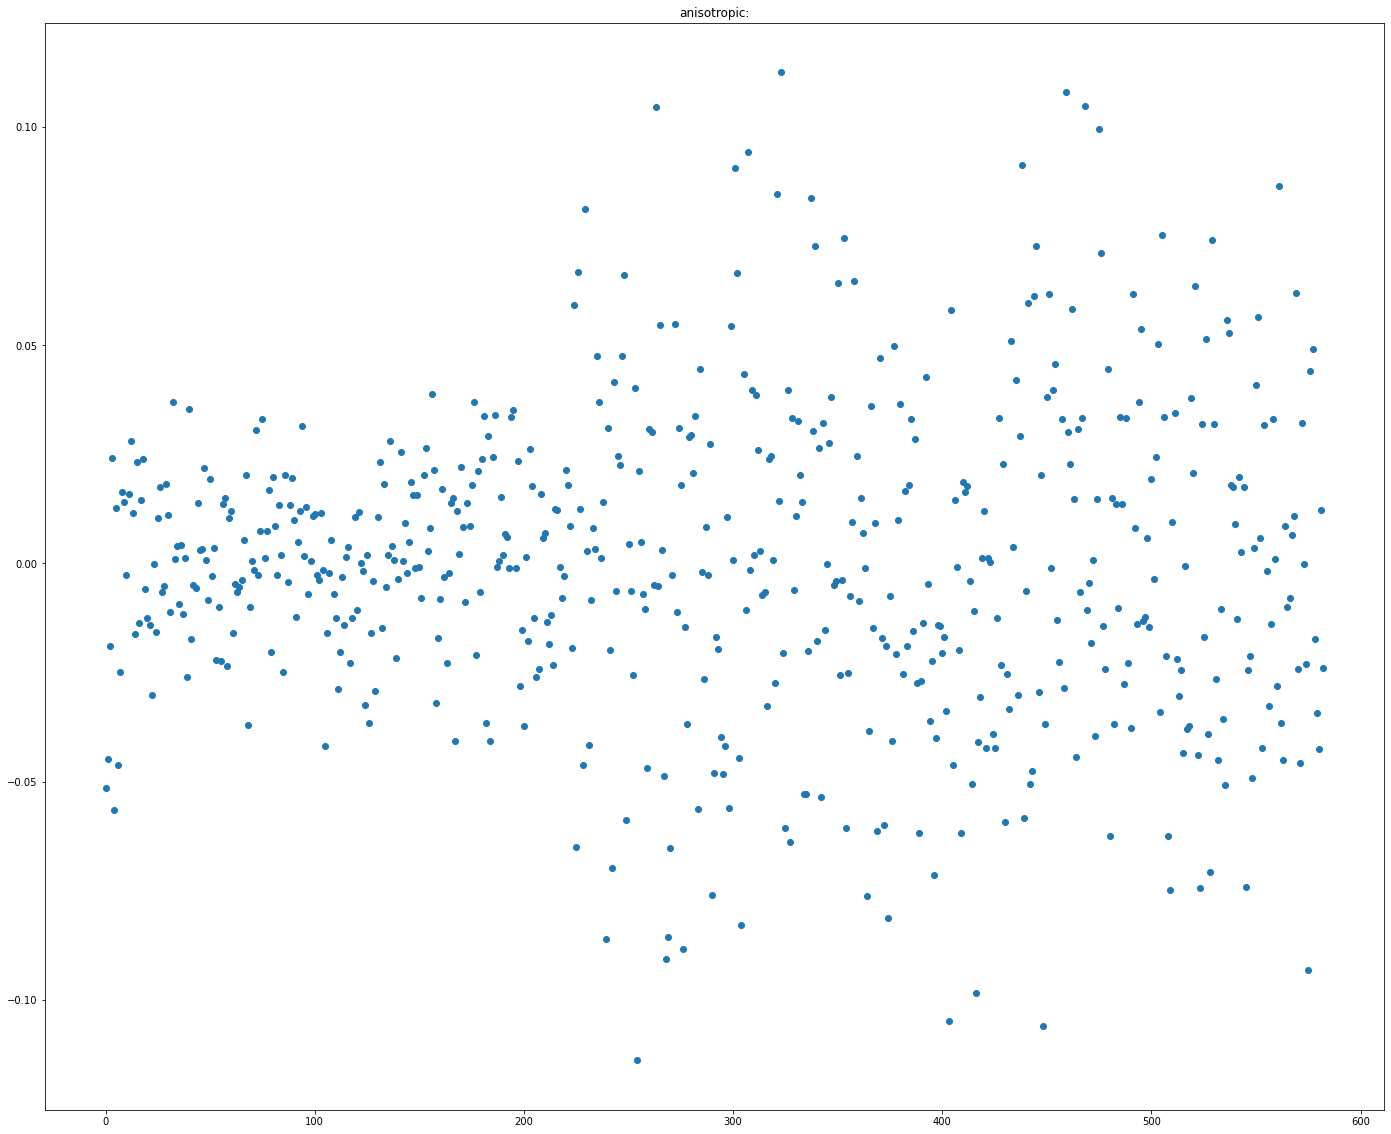

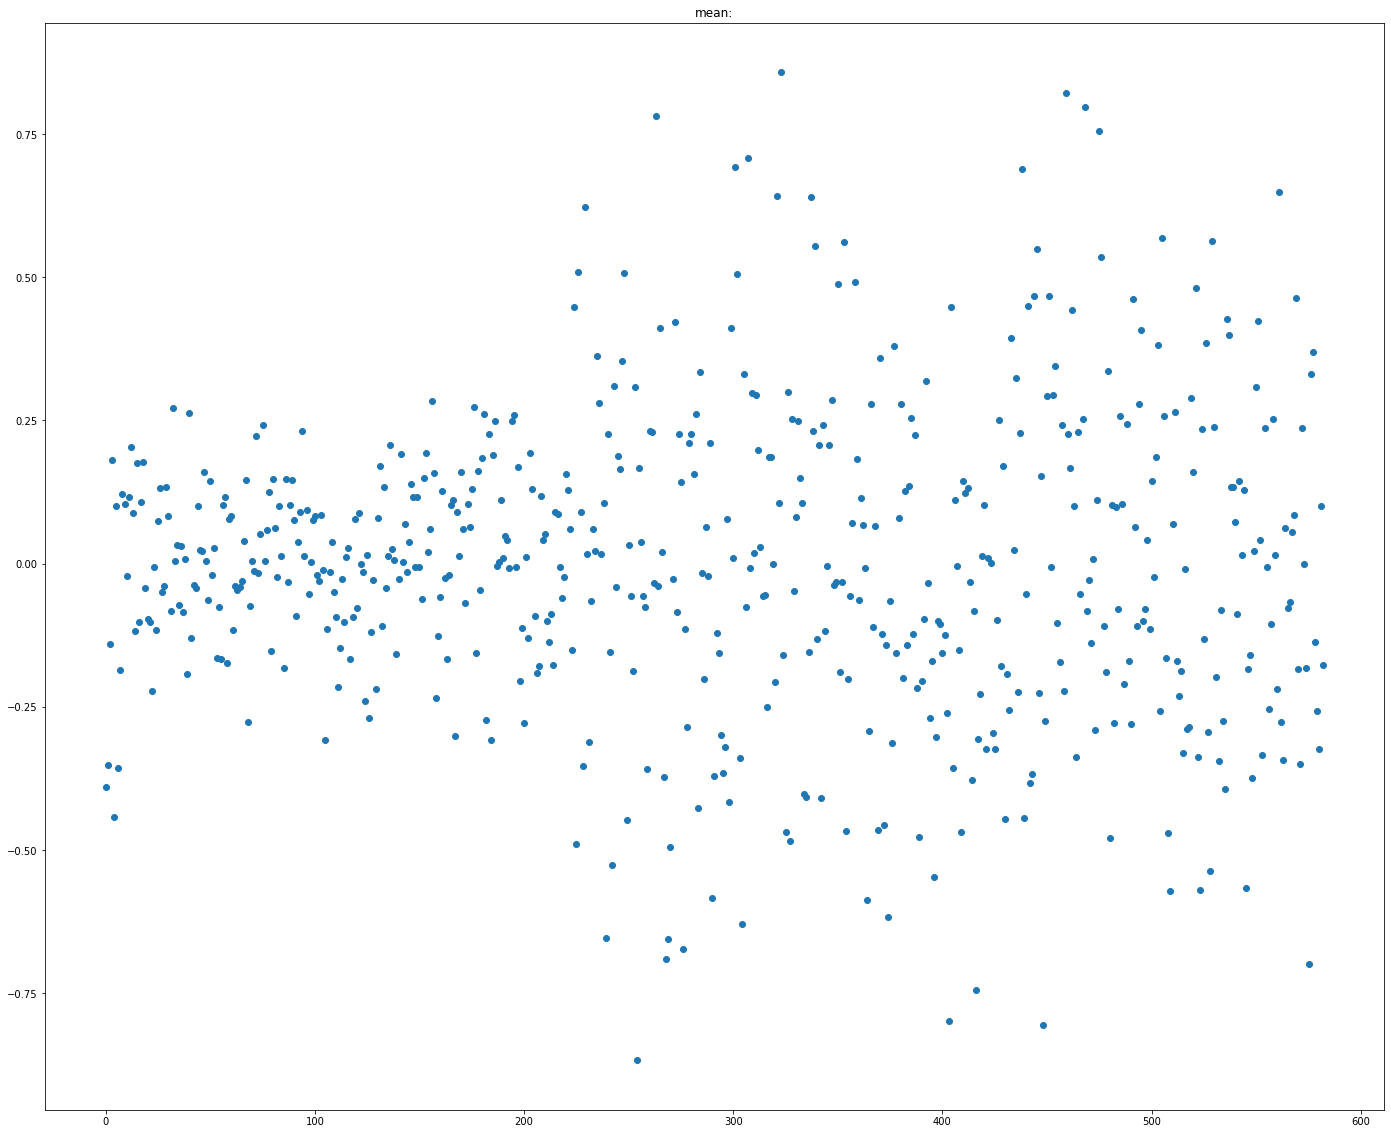

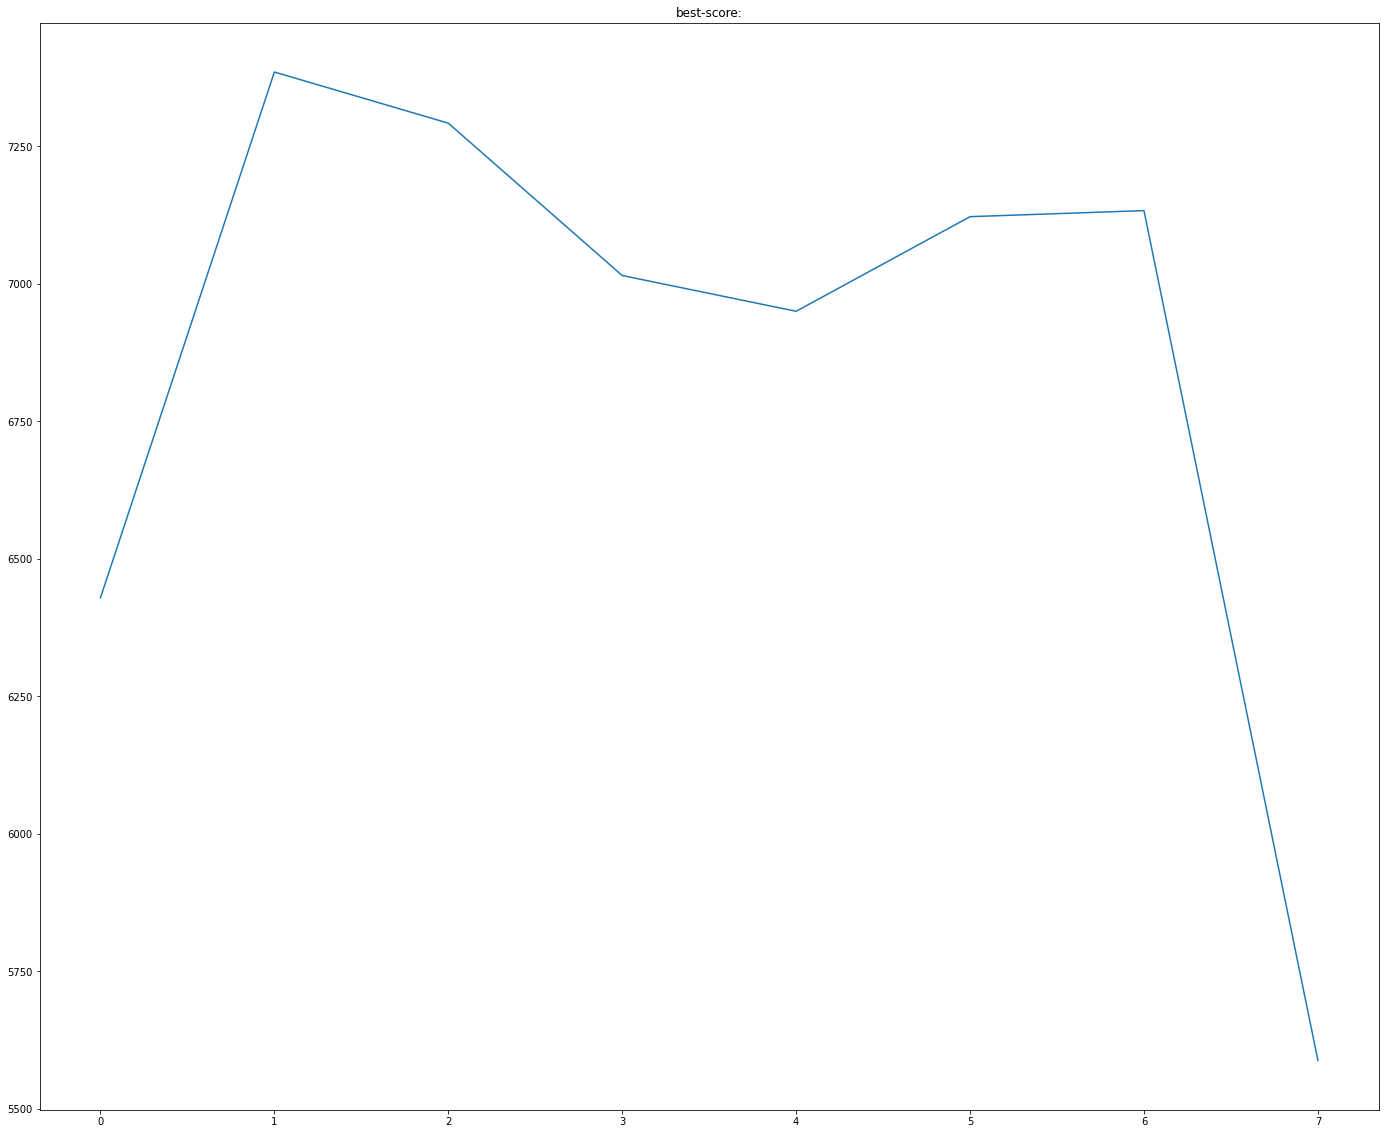

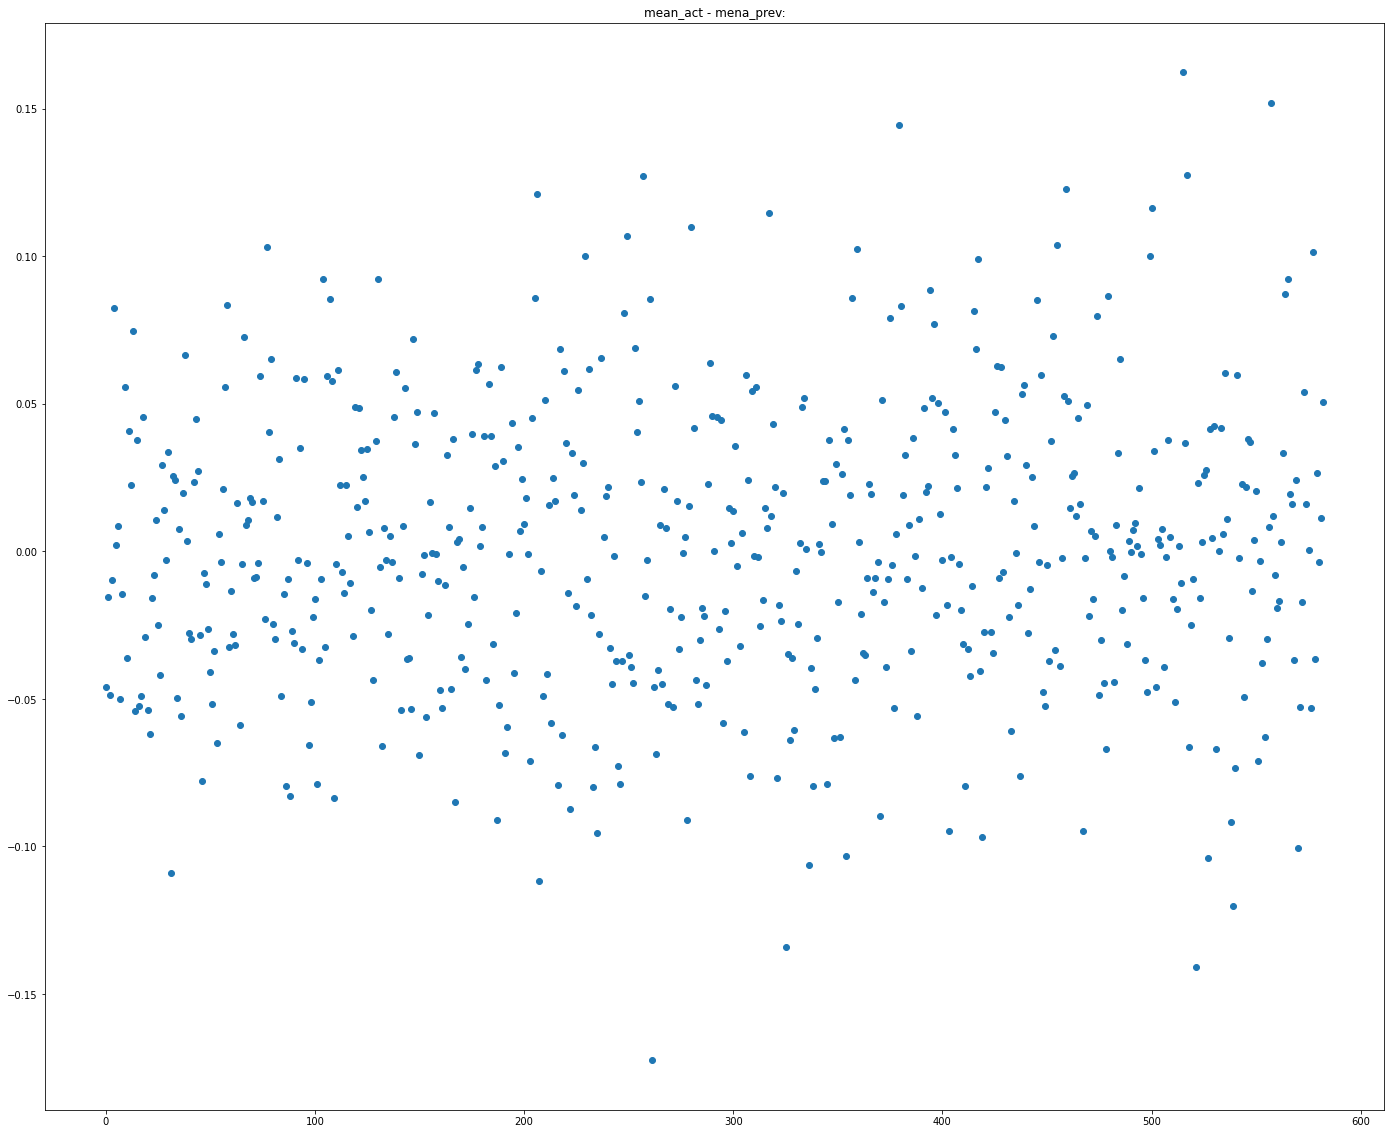

[2, 1, 1, 3, 3]
[2, 1, 13, 13]
[2, 1, 1, 3, 3]
[2, 1, 6, 6]
[2, 36, 10]


In [ ]:
classifier.fit(train_ds_mnist, POPULATION_SIZE//2, POPULATION_SIZE, 500)

In [78]:
list((1,2,3))

[1, 2, 3]